# Анализ данных о продажах игр

Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы. Необходимо выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

**Цели проекта:**
 - получить общую информацию о данных продаж игр;
 - провести предобработку данных (заменить названия столбцов, преобразовать данные в нужные тиы, обработать пропуски и посчитать суммарные продажи во всех регионах в отдельном столбце);
 - проверить, сколько игр выпускалось в разные годы;
 - посмотреть, как менялись продажи по платформам, выберать платформы с наибольшими суммарными продажами и построить распределение по годам;
 - на основе исследования предыдущих вопросов определить актуальный период для дальнейшей работы;
 - выбрать несколько потенциально прибыльных платформ;
 - построить график «ящик с усами» по глобальным продажам игр в разбивке по платформам;
 - изучить влияние отзывов пользователей и критиков на продажи популярных платформ;
 - изучить общее распределение игр по жанрам, выделить жанры с высокими и низкими продажам;
 - составить портрет пользователя каждого региона (выявить самые популярные платформы, самые популярные жанры и оценить влияние рейтинга ESRB на продажи);
 - проверить ряд гипотез;
 - сделать общий вывод о проделанной работе.

Получили и изучили общую информацию о датафрейме:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats as st
import numpy as np
import seaborn as sns
pd.set_option('display.max_rows', None)

In [2]:
game_data = pd.read_csv('/datasets/games.csv')
game_data.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [3]:
game_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Датафрейм содержит всего 16715 строк, 11 столбцов. Названия столбцов записаны некорректно. Данные имеют тип float64 и object.

# Предобработка данных

Приведем название столбцов к нижнему регистру:

In [4]:
game_data.columns = game_data.columns.str.lower()
game_data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


Посчитаем количество пропусков по всем столбцам:

In [5]:
game_data.isna().sum()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64

Пропуски имеются в 6 столбцах: больше всего пропусков в столбце с оценками критиков (8578), с оценками пользователей (6701) и рейтингом от организации ESRB (6766). Значительно меньше пропусков в столбцах с годами выпуска (269), с названием игр (2) и жанрами (2).

Т.к. пропусков с названием игр мало, и мы никак не можем их восстановить, можно удалить эти строчки:

In [6]:
game_data = game_data.dropna(subset=['name'])

Посчитаем процент пропусков в столбце с годами выпуска:

In [7]:
round(((game_data['year_of_release'].isna().sum())/(len(game_data['year_of_release'])))*100, 2)

1.61

Хоть и процент получился небольшой, заменим пропущенные значения на средние значения по платформам. Т.к. каждая платформа актуальна в определенный период времени.

Строки с пропусками в годах удаляем:

In [8]:
game_data = game_data.dropna(subset=['year_of_release'])

Процент пропусков в стобце с оценками критиков:

In [9]:
round(((game_data['critic_score'].isna().sum())/(len(game_data['critic_score'])))*100, 2)

51.45

Процент большой, это половина всех данных, удалять такое количество данных нельзя. Но и заменить эти данные невозможно т.к. нельзя выявить связи по данным категориям. Оставим пропуски.

Процент пропусков в стобце с оценками пользователей:

In [10]:
round(((game_data['user_score'].isna().sum())/(len(game_data['user_score'])))*100, 2)

40.17

Здесь также процент велик. Поступим также, как и с оценками критиков. Оставим пропуски.

В столбце с оценками пользователей встречается значение "tbd":

In [11]:
game_data['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

Количество строчек со значением "tbd":

In [12]:
len(game_data[game_data['user_score']=='tbd'])

2376

In [13]:
game_data.loc[game_data['user_score'] == 'tbd']

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
119,Zumba Fitness,Wii,2010.0,Sports,3.45,2.59,0.00,0.66,NaN,tbd,E
301,Namco Museum: 50th Anniversary,PS2,2005.0,Misc,2.08,1.35,0.00,0.54,61.0,tbd,E10+
520,Zumba Fitness 2,Wii,2011.0,Sports,1.51,1.03,0.00,0.27,NaN,tbd,T
645,uDraw Studio,Wii,2010.0,Misc,1.65,0.57,0.00,0.20,71.0,tbd,E
718,Just Dance Kids,Wii,2010.0,Misc,1.52,0.54,0.00,0.18,NaN,tbd,E
726,Dance Dance Revolution X2,PS2,2009.0,Simulation,1.09,0.85,0.00,0.28,NaN,tbd,E10+
821,The Incredibles,GBA,2004.0,Action,1.15,0.77,0.04,0.10,55.0,tbd,E
881,Who wants to be a millionaire,PC,1999.0,Misc,1.94,0.00,0.00,0.00,NaN,tbd,E
1047,Tetris Worlds,GBA,2001.0,Puzzle,1.25,0.39,0.00,0.06,65.0,tbd,E
1048,Imagine: Teacher,DS,2008.0,Simulation,0.70,0.82,0.00,0.19,NaN,tbd,E


Изучив строки со значениями оцнки пользователей "tbd", можно зделать вывод, что у большинства строчек оценки критиков не определены. Продажи в Японии в таких строчках почти везде нулевые, продажи в других странах тоже незначительны. Скорее всего, это рейтинг еще не определен. Таких строчек довольно много, удалять их нельзя. Заменим эти значения на "NaN":

Замена значения tbd на NaN

In [14]:
game_data.replace('tbd', np.nan, inplace=True)

Процент пропусков в стобце с рейтингом организации ESRB:

In [15]:
round(((game_data['rating'].isna().sum())/(len(game_data['rating'])))*100, 2)

40.6

Это тоже большой процент, такие данные удалять нельзя. Заменим неопределенный рейтинг на "unknown":

In [16]:
game_data['rating'] = game_data['rating'].fillna('unknown')

Заменим типы данных на подходящий для дальнейших исследований:

In [17]:
game_data = game_data.astype({'year_of_release':'int64', 'user_score':'float64'})

Проверим результат обработки данных:

In [18]:
game_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  int64  
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     7983 non-null   float64
 9   user_score       7463 non-null   float64
 10  rating           16444 non-null  object 
dtypes: float64(6), int64(1), object(4)
memory usage: 1.5+ MB


Проверим данные на явные дубликаты:

In [19]:
game_data.duplicated().sum()

0

Явных дубликатов не обнаружено.

Проведем проверку на наличие неявных дубликатов по столбцам: 'name', 'platfom', 'year_of_release':

In [20]:
game_data[game_data.duplicated(['year_of_release', 'name', 'platform'])]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
16230,Madden NFL 13,PS3,2012,Sports,0.0,0.01,0.0,0.0,83.0,5.5,E


In [21]:
game_data.loc[game_data['name'] == 'Madden NFL 13']

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
507,Madden NFL 13,X360,2012,Sports,2.53,0.15,0.0,0.17,81.0,5.8,E
604,Madden NFL 13,PS3,2012,Sports,2.11,0.22,0.0,0.23,83.0,5.5,E
3986,Madden NFL 13,Wii,2012,Sports,0.47,0.00,0.0,0.03,NaN,7.3,E
5887,Madden NFL 13,PSV,2012,Sports,0.28,0.00,0.0,0.02,63.0,7.3,E
7066,Madden NFL 13,WiiU,2012,Sports,0.21,0.00,0.0,0.02,75.0,6.7,E
16230,Madden NFL 13,PS3,2012,Sports,0.00,0.01,0.0,0.00,83.0,5.5,E


Игра "Madden NFL 13" в 2012 году выпускалась на разных платформах, но есть строчка, дублирующая выход на PS3, но некоторые значения в ней пропущены. Оставим строчку с полной информацией, а дублирующую - удалим.

In [22]:
game_data = game_data.drop (index= 16230)

Посчитали суммарные продажи во всех регионах и записали их в отдельный столбец с названием 'total_sales':

In [23]:
game_data['total_sales'] = game_data[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].sum(axis=1)
game_data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,unknown,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,unknown,31.38


**Промежуточный вывод:** 
 - в ходе предобработки данных были приведены названия столбцов к нижнему регистру;
 - также обнаружили пропуски в 6 столбцах (в столбце с оценками критиков (51.31 %), с оценками пользователей (40.08 %) и рейтингом от организации ESRB (40.47), значительно меньше пропусков в столбцах с годами выпуска, с названием игр и жанрами). Пропуски были обработаны разными способами;
 - был изменен тип данных: "Год выпска" с типа float на integer, "оценки пользователей" с типа object на float;
 - данные проверили на наличие явных дубликатов: дубликатов не обнаружено;
 - добавили столбец 'total_sales' с суммарными продажами по всем регионам.

# Исследовательский анализ

### Cколько игр выпускалось в разные годы

Построим сводную таблицу с указанием количества игр и их процентом по годам:

In [24]:
distribution_by_year = game_data.pivot_table(index=[ 'year_of_release'], values=['name'], aggfunc={'count'})
sum_games = game_data['year_of_release'].value_counts().sum()
distribution_by_year.columns =['games_count']
distribution_by_year['percent'] = round((distribution_by_year['games_count']/sum_games)*100, 2)
distribution_by_year.sort_values(by='percent', ascending=False).reset_index()

,year_of_release,games_count,percent
0,2008,1427,8.68
1,2009,1426,8.67
2,2010,1255,7.63
3,2007,1197,7.28
4,2011,1136,6.91
5,2006,1006,6.12
6,2005,939,5.71
7,2002,829,5.04
8,2003,775,4.71
9,2004,762,4.63


Для визаулизации данных использовали столбчатую диаграмму:

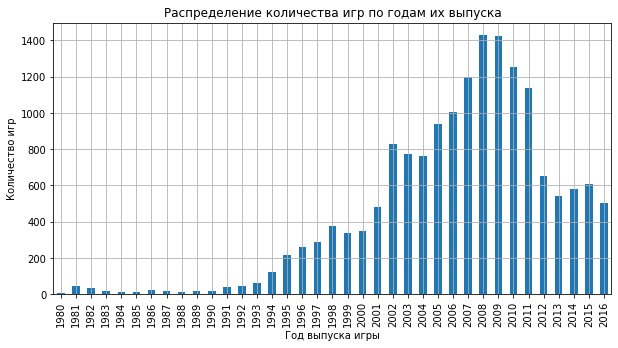

In [25]:
distribution_by_year['games_count'].plot.bar(figsize=(10, 5), grid=True)
plt.title('Распределение количества игр по годам их выпуска');
plt.xlabel('Год выпуска игры');
plt.ylabel('Количество игр');
plt.show()

Максимальное число игр выпускалось в 2008 году (9.12 %). Наибольшее количество игр выпускалось в период с 2005 по 2011 год, далее идет спад, обусловленный, по-видимому, меньшему интересу к играм. Минимальное количество игр было выпущено в 1980 году (0.05 %). Если опираться на количество игр, то до 2002 года данные не так интересны. Наиболее актуальные период для исследования от 2005 года.

### Как менялись продажи по платформам

Выявим платформы с наибольшими суммарными продажами:

In [26]:
platform_sales = game_data.pivot_table(index=['platform'], values=['total_sales'], aggfunc={'sum'})
platform_sales.columns =['total_sales']
platform_sales.sort_values(by='total_sales', ascending=False).reset_index()

,platform,total_sales
0,PS2,1233.56
1,X360,961.24
2,PS3,931.33
3,Wii,891.18
4,DS,802.78
5,PS,727.58
6,PS4,314.14
7,GBA,312.88
8,PSP,289.53
9,3DS,257.81


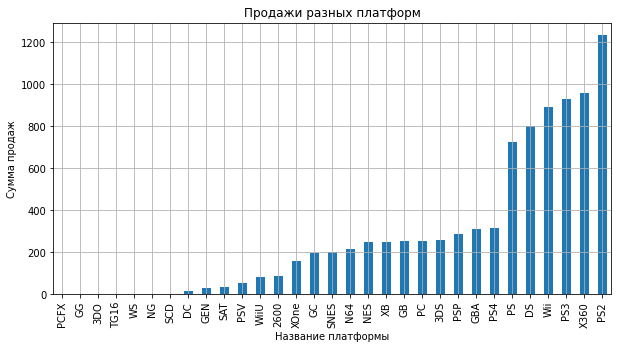

In [27]:
platform_sales['total_sales'].sort_values(ascending=True).plot.bar(figsize=(10, 5), grid=True)
plt.title('Продажи разных платформ');
plt.xlabel('Название платформы');
plt.ylabel('Сумма продаж');
plt.show()

По графику видно, что лидером продаж является платформа PS2. Также, на графике видно, что 6 платформ (PS2, X360, PS3, Wii, DS, PS) значительно превосходят по продажам все остальные платформы.

Выведем 10 платформ, лидирующих по продажам:

In [28]:
ten_platform = platform_sales.query('total_sales > 257')
ten_platform.sort_values(by='total_sales', ascending=False).reset_index()

,platform,total_sales
0,PS2,1233.56
1,X360,961.24
2,PS3,931.33
3,Wii,891.18
4,DS,802.78
5,PS,727.58
6,PS4,314.14
7,GBA,312.88
8,PSP,289.53
9,3DS,257.81


Создали список из шести лидирующих по продажам платформ для дальнгейшего исследования

In [29]:
top_six = platform_sales.groupby('platform').agg({'total_sales': 'sum'}).sort_values(by='total_sales', ascending=False).head(6).index.to_list()
top_six

['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS']

In [30]:
act_platform = game_data.query('platform == @top_six')

В ходе построения графика продаж платформы DS был замечен аномальный пик в районе 1985 года. Это ошибочные данные. Было принято решение - удалить эту строчку.

In [31]:
act_platform.loc[(act_platform['platform'] == 'DS') & (act_platform['year_of_release'] < 2000)]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
15957,Strongest Tokyo University Shogi DS,DS,1985,Action,0.0,0.0,0.02,0.0,NaN,NaN,unknown,0.02


In [32]:
act_platform = act_platform.drop(index=15957)

Вывели общую информацию по 6 платформам:

In [33]:
act_platform_fin = act_platform.pivot_table(index=['platform', 'year_of_release'], values=['total_sales'], aggfunc={'sum'})                                                                                         
act_platform_fin.columns = ['total_sales']
act_platform_fin

total_sales
platform year_of_release             
DS       2004                   17.27
         2005                  130.14
         2006                  119.81
         2007                  146.94
         2008                  145.31
         2009                  119.54
         2010                   85.02
         2011                   26.18
         2012                   11.01
         2013                    1.54
PS       1994                    6.03
         1995                   35.96
         1996                   94.70
         1997                  136.17
         1998                  169.49
         1999                  144.53
         2000                   96.37
         2001                   35.59
         2002                    6.67
         2003                    2.07
PS2      2000                   39.17
         2001                  166.43
         2002                  205.38
         2003                  184.31
         2004                  211.81
         2005                  160.66
         2006                  103.42
         2007                   75.99
         2008                   53.90
         2009                   26.40
         2010                    5.64
         2011                    0.45
PS3      2006                   20.96
         2007                   73.19
         2008                  118.52
         2009                  130.93
         2010                  142.17
         2011                  156.78
         2012                  107.35
         2013                  113.25
         2014                   47.76
         2015                   16.82
         2016                    3.60
Wii      2006                  137.15
         2007                  152.77
         2008                  171.32
         2009                  206.97
         2010                  127.95
         2011                   59.65
         2012                   21.71
         2013                    8.59
         2014                    3.75
         2015                    1.14
         2016                    0.18
X360     2005                    8.25
         2006                   51.62
         2007                   95.41
         2008                  135.26
         2009                  120.29
         2010                  170.03
         2011                  143.84
         2012                   99.74
         2013                   88.58
         2014                   34.74
         2015                   11.96
         2016                    1.52

In [34]:
# код ревьюера
act_platform.groupby('platform')['year_of_release'].nunique().median()

11.0

Средний период актуальности платформ составляет 11 лет.

Далее, построим диаграммы изменения количества игр каждой, из шести лидирующих по продажам, платформы по годам:

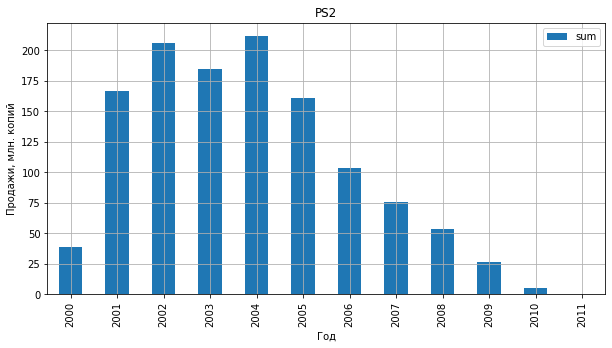

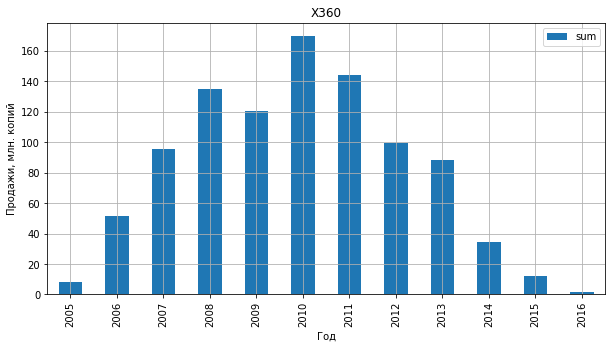

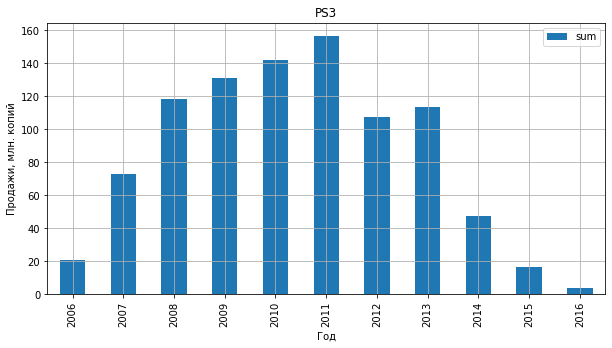

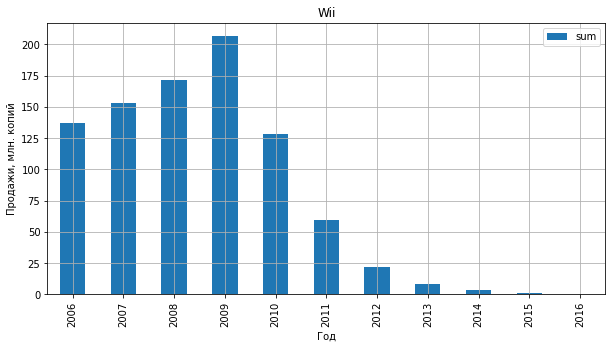

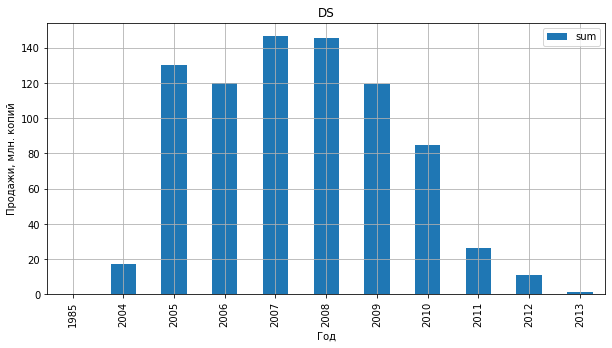

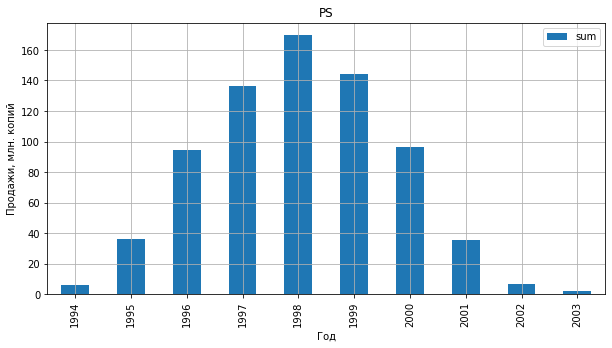

In [35]:
for platform in top_six:
    platform_table = game_data.query('platform == @platform').pivot_table(index='year_of_release', values='total_sales', aggfunc={'sum'})
    platform_table.plot.bar(figsize=(10, 5), grid=True)
    plt.xlabel('Год');
    plt.ylabel('Продажи, млн. копий')
    plt.title(platform);

Изучив диаграммы распределения продаж игр по годам внутри платформы, можно сделать вывод, что у всех платформ сначала идет постепенный рост продаж игр с течением времени, затем достигается пиковое значеие, и далее идет спад, т.к.теряется актуальность платформы.

Визуализируем изменение продаж разных платформ с течением времени:

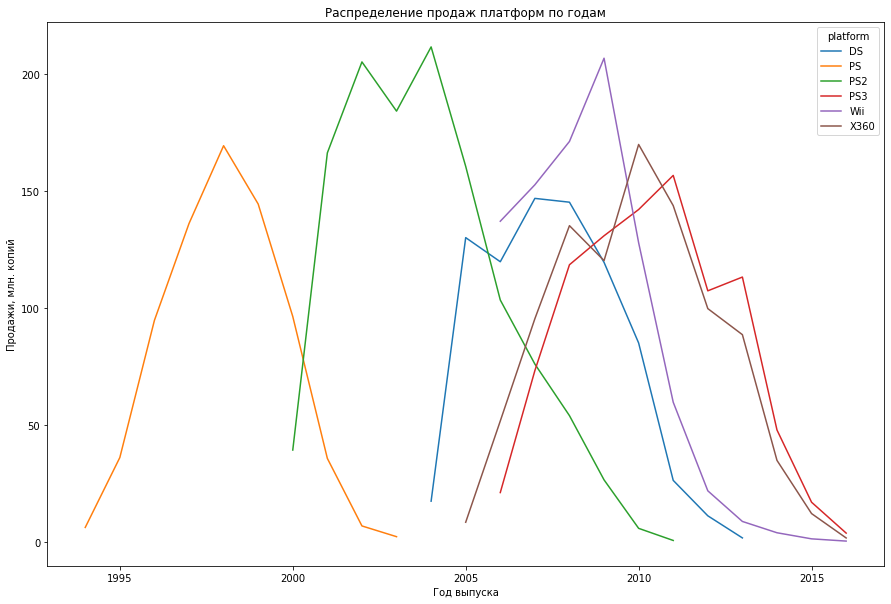

In [36]:
plt.figure(figsize=(15, 10))
p_t_y = act_platform.groupby(['platform', 'year_of_release'])['total_sales'].sum()
sns.lineplot(x='year_of_release',y='total_sales', hue='platform', data=p_t_y.reset_index()).set (title='Распределение продаж платформ по годам');
plt.xlabel('Год выпуска');
plt.ylabel('Продажи, млн. копий');

Все вышесказанное подтверждается на этом графике. В среднем, за период в 10 лет исчезают старые и появляются новые платформы. 2008-2011 год характеризуются максимальной актуальностью сразу четырех платформ: DS, Wii, X360 и PS3.

### Актуальный период для дальнейших исследований

Исходя из предыдущих исследований выбираем актуальный период для дальнейших исследований, начиная с 2013 года с учетом того, что данные должны помочь построить прогноз на 2017 год.

In [37]:
actual_period = game_data.query('year_of_release >= 2013')

In [38]:
actual_period.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2233 entries, 16 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             2233 non-null   object 
 1   platform         2233 non-null   object 
 2   year_of_release  2233 non-null   int64  
 3   genre            2233 non-null   object 
 4   na_sales         2233 non-null   float64
 5   eu_sales         2233 non-null   float64
 6   jp_sales         2233 non-null   float64
 7   other_sales      2233 non-null   float64
 8   critic_score     991 non-null    float64
 9   user_score       1192 non-null   float64
 10  rating           2233 non-null   object 
 11  total_sales      2233 non-null   float64
dtypes: float64(7), int64(1), object(4)
memory usage: 226.8+ KB


### Какие платформы лидируют по продажам

Выведем и визуализируем информацию о продажах платформ за актуальный период:

In [39]:
a_p_table = actual_period.pivot_table(index=['platform', 'year_of_release'], values='total_sales', aggfunc = 'sum')
a_p_table

total_sales
platform year_of_release             
3DS      2013                   56.57
         2014                   43.76
         2015                   27.78
         2016                   15.14
DS       2013                    1.54
PC       2013                   12.38
         2014                   13.28
         2015                    8.52
         2016                    5.25
PS3      2013                  113.25
         2014                   47.76
         2015                   16.82
         2016                    3.60
PS4      2013                   25.99
         2014                  100.00
         2015                  118.90
         2016                   69.25
PSP      2013                    3.14
         2014                    0.24
         2015                    0.12
PSV      2013                   10.59
         2014                   11.90
         2015                    6.25
         2016                    4.25
Wii      2013                    8.59
         2014                    3.75
         2015                    1.14
         2016                    0.18
WiiU     2013                   21.65
         2014                   22.03
         2015                   16.35
         2016                    4.60
X360     2013                   88.58
         2014                   34.74
         2015                   11.96
         2016                    1.52
XOne     2013                   18.96
         2014                   54.07
         2015                   60.14
         2016                   26.15

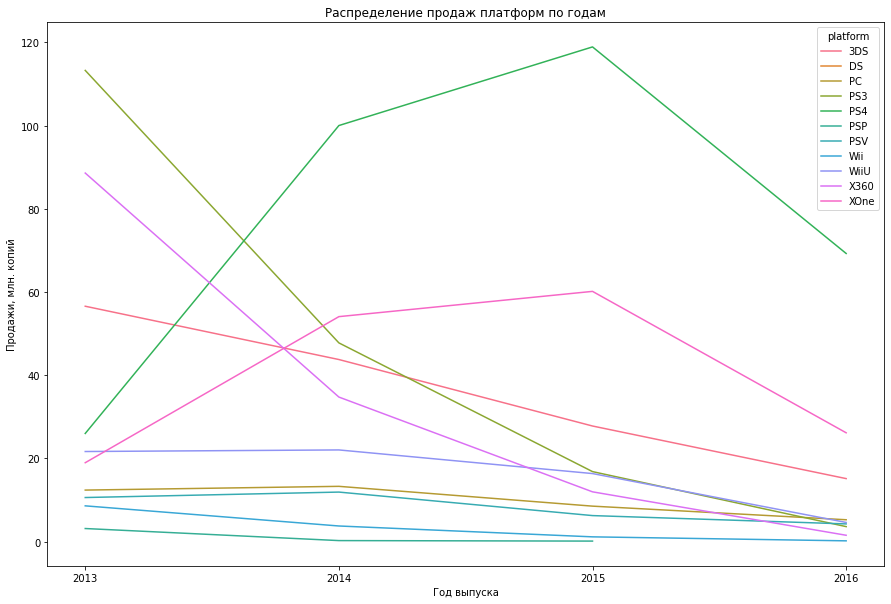

In [40]:
plt.figure(figsize=(15, 10))
act_per_data = a_p_table.groupby(['platform', 'year_of_release'])['total_sales'].sum()
sns.lineplot(x='year_of_release',y='total_sales', hue='platform', data=act_per_data.reset_index()).set (title='Распределение продаж платформ по годам');
plt.xticks([2013, 2014, 2015, 2016]);
plt.xlabel('Год выпуска');
plt.ylabel('Продажи, млн. копий');

Рейтинг по продажам возглавляет платформа PS4. Далее идет платформа PS3, но на графике наблюдается сильный спад продаж на момент 2016 года. На третьем месте платформа XOne, на четвертом 3DS, на пятом X360. Потенциально прибыльными можно назвать PS4, XOne и 3DS. Однако, на графике виден их постепенный спад продаж на 2016 год.

### Диаграмма размаха глобальных продаж игр в разбивке по платформам

In [41]:
actual_period.pivot_table(index='platform', values='total_sales', aggfunc = 'sum').sort_values(by='total_sales', ascending=False).reset_index()

,platform,total_sales
0,PS4,314.14
1,PS3,181.43
2,XOne,159.32
3,3DS,143.25
4,X360,136.80
5,WiiU,64.63
6,PC,39.43
7,PSV,32.99
8,Wii,13.66
9,PSP,3.50


Вывели описательную информацию продаж разных платформ:

In [42]:
actual_period.groupby('platform')['total_sales'].describe()

,count,mean,std,min,25%,50%,75%,max
platform,,,,,,,,
3DS,303.0,0.472772,1.381347,0.01,0.0400,0.090,0.2800,14.60
DS,8.0,0.192500,0.172026,0.03,0.0675,0.150,0.2525,0.51
PC,189.0,0.208624,0.352304,0.01,0.0300,0.080,0.2300,3.05
PS3,345.0,0.525884,1.451939,0.01,0.0400,0.150,0.5100,21.05
PS4,392.0,0.801378,1.609456,0.01,0.0600,0.200,0.7300,14.63
PSP,67.0,0.052239,0.059768,0.01,0.0150,0.020,0.0700,0.24
PSV,358.0,0.092151,0.153816,0.01,0.0200,0.040,0.1100,1.96
Wii,23.0,0.593913,0.915432,0.01,0.0450,0.180,0.7550,3.58
WiiU,115.0,0.562000,1.038778,0.01,0.0600,0.200,0.5950,7.09


Стандартное отклонение подавляющего большинства платформ говорит о большом разбросе значений продаж. Наименьшее отклонение от среднего у платформы DS (но у нее очень мало значений), максимальное отклонение у платформы X360.

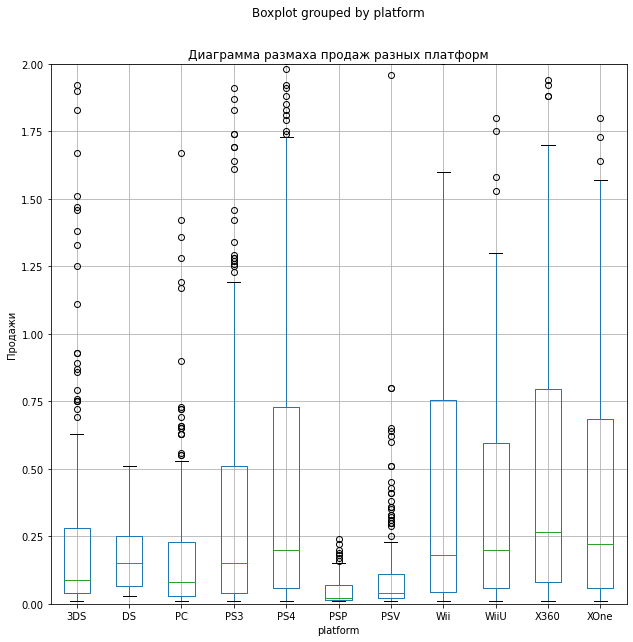

In [43]:
actual_period.boxplot(by='platform', column=['total_sales'], figsize=(10, 10));
plt.title('Диаграмма размаха продаж разных платформ');
plt.ylabel('Продажи');
plt.ylim(0, 2)
plt.show()

На графике можно заметить, что максимальное медианное значение продаж у платформы X360, это связано с тем, что у нее больший расброс значений. Это касается и остальных платформ, у них много выбросов. По данному графику можно выявить лидеров продаж: X360, Wii, PS4, XOne.

Большое количество выбросов можно связать с высокой популярность игр и с большим числом продаж данных платформ.

### Влияние отзывов пользователей и критиков на продажи внутри платформы

Создадим список с платформами, интересными для исследования</b> 

In [44]:
top_platform = actual_period.groupby('platform').agg({'total_sales': 'sum'}).sort_values(by='total_sales', ascending=False).head(5).index.to_list()
platform

'PS'

<div class="alert alert-block alert-info">
<b>Функция для построения таблицы с коэффициентами корреляции.</b> 


In [45]:
def coef_corr (platform):
    data_table = actual_period.query('platform == @platform')
    data_platform_table = data_table.pivot_table(index='name', values=['total_sales', 'critic_score', 'user_score'])
    return data_platform_table.corr()

In [46]:
coef_corr ('PS4')

,critic_score,total_sales,user_score
critic_score,1.000000,0.406568,0.557654
total_sales,0.406568,1.000000,-0.031957
user_score,0.557654,-0.031957,1.000000


In [47]:
coef_corr ('PS3')

,critic_score,total_sales,user_score
critic_score,1.000000,0.334285,0.599920
total_sales,0.334285,1.000000,0.002394
user_score,0.599920,0.002394,1.000000


In [48]:
coef_corr ('XOne')

,critic_score,total_sales,user_score
critic_score,1.000000,0.416998,0.472462
total_sales,0.416998,1.000000,-0.068925
user_score,0.472462,-0.068925,1.000000


In [49]:
coef_corr ('3DS')

,critic_score,total_sales,user_score
critic_score,1.000000,0.357057,0.769536
total_sales,0.357057,1.000000,0.241504
user_score,0.769536,0.241504,1.000000


In [50]:
coef_corr ('X360')

,critic_score,total_sales,user_score
critic_score,1.000000,0.350345,0.520946
total_sales,0.350345,1.000000,-0.011742
user_score,0.520946,-0.011742,1.000000


Исходя из значений корреляции, связь между продажами и оценкой пользователей очень слабая, отрицательный знак коэффициента корреляции говорит о ее обратнопропорциональности. Связь между продажами и оценкой критиков чуть сильнее, но она тоже незначительна и прямопропорциональна.

Функция для построения диаграмм рассеяния значений продаж в зависимости от оценок критиков.

In [51]:
def scatter_plot (platform):
    data_plot = actual_period.query('platform == @platform')
    data_plot.pivot_table(index='critic_score', values='total_sales').plot(grid=True, style='o', figsize=(10, 5));
    plt.xlabel('Оценка критиков');
    plt.ylabel('Продажи');
    plt.title(platform);

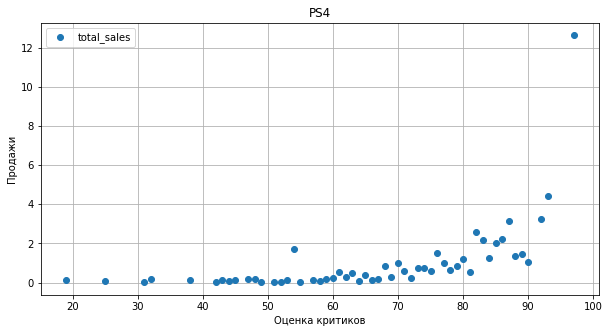

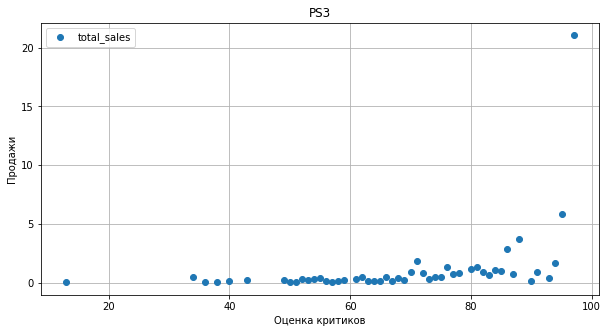

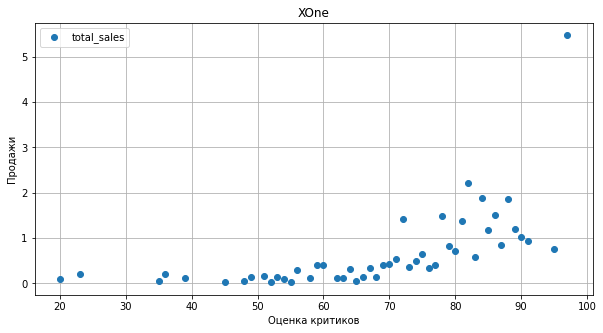

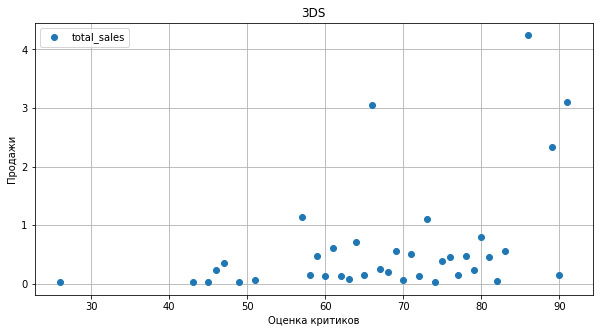

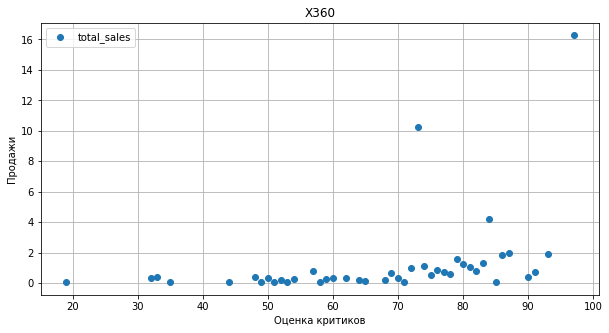

In [52]:
for platforms in top_platform:
    scatter_plot (platforms)

На диаграмме рассеяния прослеживается небольшая прямопропорциональная связь между продажами и оценками критиков. Также видно, что она нелинейная.

Функция для построения диаграмм рассеяния значений продаж в зависимости от оценок пользователей.

In [53]:
def scatter_plot_user (platform):
    data_plot = actual_period.query('platform == @platform')
    data_plot.pivot_table(index='user_score', values='total_sales').plot(grid=True, style='o', figsize=(10, 5));
    plt.xlabel('Оценка пользователей');
    plt.ylabel('Продажи');
    plt.title(platform);

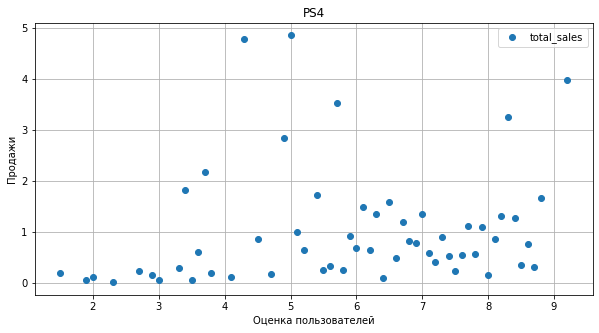

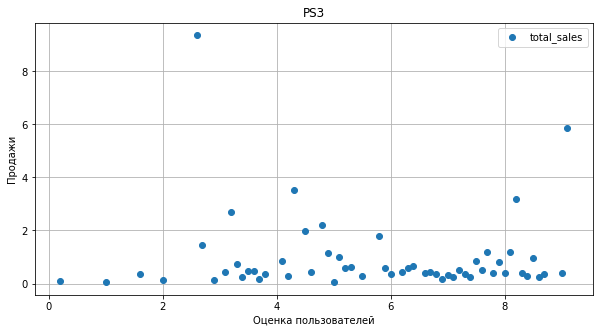

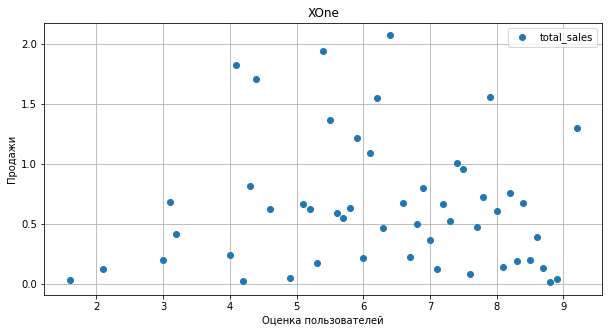

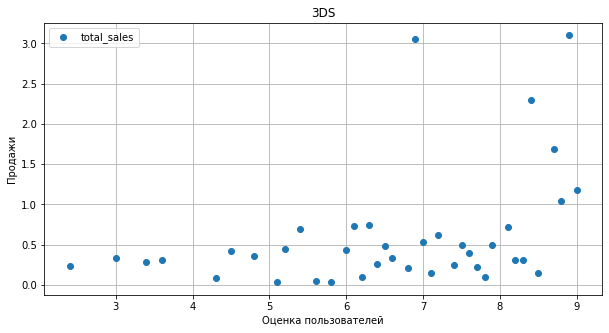

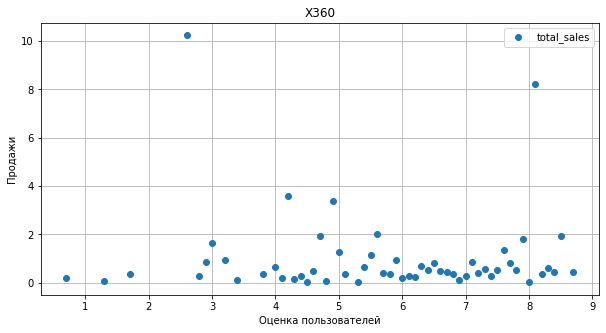

In [54]:
for platforms in top_platform:
    scatter_plot_user (platforms)

Здесь связи между продажами и оценками пользователей не наблюдается.

Изучив данные по пяти платформам, можно сделать вывод, что коэффициент корреляции продаж и оценок критиков у всех платформах имеет значение около 0.4. Это говорит о небольшой прямопропорциональной связи. Это можно наблюдать на диаграммах рассеяния. С увеличением оценки критика растут продажи платформы. Коэффициент корреляции продаж и оценок пользователей на всех платформах на уровне 0.03, это говорит, что связи практически нет между этими параметрами.

### Общее распределение игр по жанрам

Выведем и визуализируем информацию о распределении игр по жанрам:

In [55]:
distribution_by_genre = actual_period.pivot_table(index=['genre'], values=['name'], aggfunc={'count'})
distribution_by_genre.columns =['count']
distribution_by_genre.sort_values(by='count', ascending=False).reset_index()

,genre,count
0,Action,766
1,Role-Playing,292
2,Adventure,245
3,Sports,214
4,Shooter,187
5,Misc,155
6,Racing,85
7,Fighting,80
8,Platform,74
9,Simulation,62


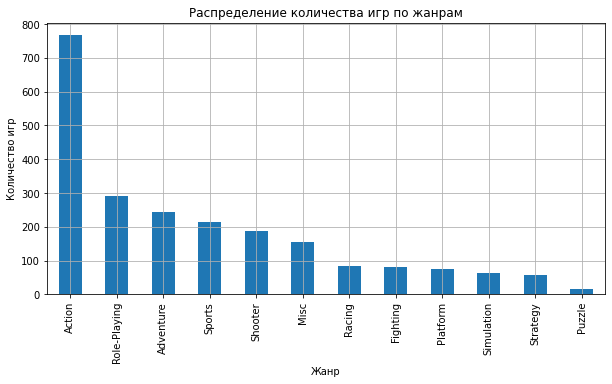

In [56]:
distribution_by_genre['count'].sort_values(ascending=False).plot.bar(figsize=(10, 5), grid=True)
plt.title('Распределение количества игр по жанрам');
plt.xlabel('Жанр');
plt.ylabel('Количество игр');
plt.show()

Самым часто выпускаемым жанром можно назвать Action, у него большой отрыв в сравнении с остальными жанрами. Топ-5 выпускаемых жанров: Action, Role-Playing, Adventure, Sports и Shooter. Самый не популярный жанр - Puzzle.

Выведем и визуализируем данные о медианных продажах разных жанров:

In [57]:
genre_sales = actual_period.pivot_table(index=['genre'], values=['total_sales'], aggfunc={'median'})
genre_sales.columns =['total_sales']
genre_sales.sort_values(by='total_sales', ascending=False).reset_index()

,genre,total_sales
0,Shooter,0.450
1,Sports,0.240
2,Platform,0.225
3,Role-Playing,0.125
4,Fighting,0.125
5,Racing,0.120
6,Action,0.110
7,Simulation,0.100
8,Misc,0.100
9,Strategy,0.080


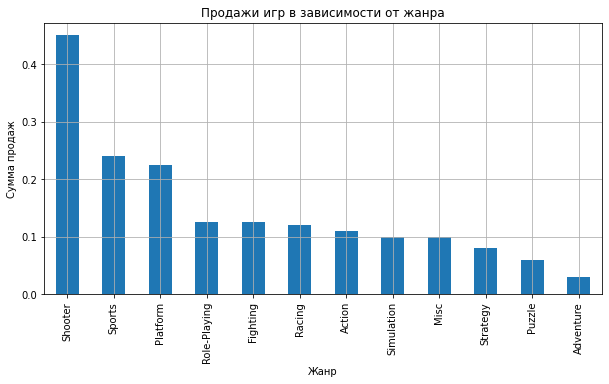

In [58]:
genre_sales['total_sales'].sort_values(ascending=False).plot.bar(figsize=(10, 5), grid=True)
plt.title('Продажи игр в зависимости от жанра');
plt.xlabel('Жанр');
plt.ylabel('Сумма продаж');
plt.show()

Диаграмма размаха для оценки медиан продаж

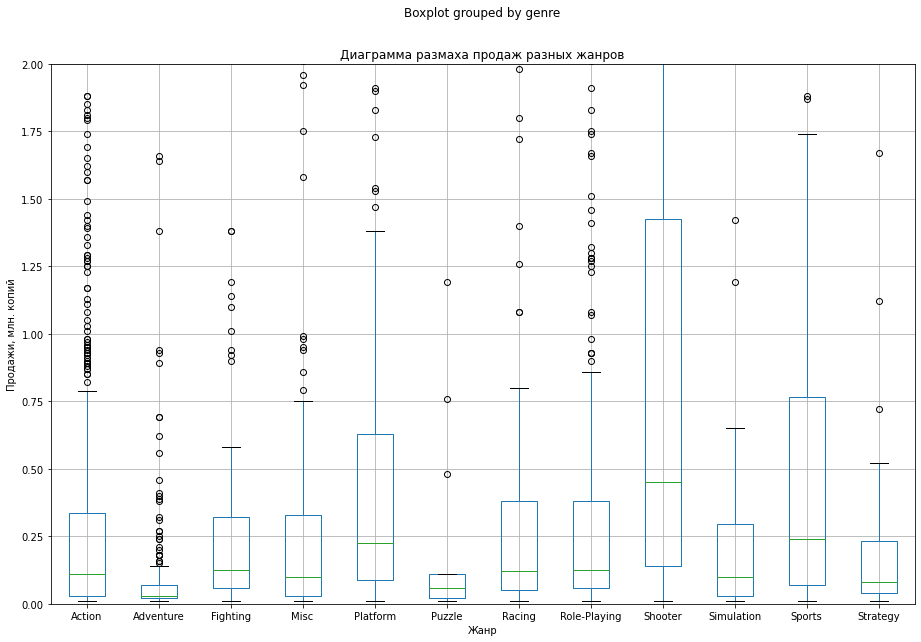

In [59]:
actual_period.boxplot(by='genre', column=['total_sales'], figsize=(15, 10));
plt.title('Диаграмма размаха продаж разных жанров');
plt.ylabel('Продажи, млн. копий');
plt.xlabel('Жанр');
plt.ylim(0, 2)
plt.show()

Лидером продаж также является жанр Action. Далее идет Shooter, Sports, Role-Playing и Misc. Пятерка лидеров немного изменилась. Наименьшие продажи также имеет жанр Puzzle.

Лидером продаж является жанр Shooter, далее идут: Sports, Platform, Role-Playing и Fighting. Наименьшие продажи у жанра Adventure.

### Портрет пользователя каждого региона

Выведем и визуализируем продажи платформ в Северной Америке:

In [60]:
na_rating = actual_period.pivot_table(index='platform', values=['name', 'na_sales'], aggfunc={'name': 'count', 'na_sales': 'sum'})
na_rating.columns = ['na_sales', 'count']
na_rating['sales_share'] = round(na_rating['na_sales'] / (na_rating['na_sales'].sum()), 2)
na_platform = na_rating.sort_values(by='na_sales', ascending=False).reset_index()
na_platform

,platform,na_sales,count,sales_share
0,PS4,108.74,392,0.25
1,XOne,93.12,247,0.21
2,X360,81.66,186,0.19
3,PS3,63.50,345,0.15
4,3DS,38.20,303,0.09
5,WiiU,29.21,115,0.07
6,PC,11.11,189,0.03
7,Wii,6.56,23,0.01
8,PSV,5.04,358,0.01
9,DS,0.57,8,0.00


In [61]:
na_platform.loc[5:,'platform'] = 'Other'
na_plot = na_platform.groupby('platform')['na_sales'].sum()

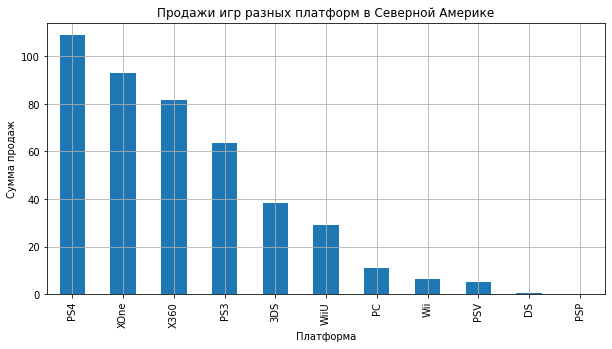

In [62]:
na_rating['na_sales'].sort_values(ascending=False).plot.bar(figsize=(10, 5), grid=True)
plt.title('Продажи игр разных платформ в Северной Америке');
plt.xlabel('Платформа');
plt.ylabel('Сумма продаж');
plt.show()

Топ-5 платформ, лидирующих по продажам в Северной Америке

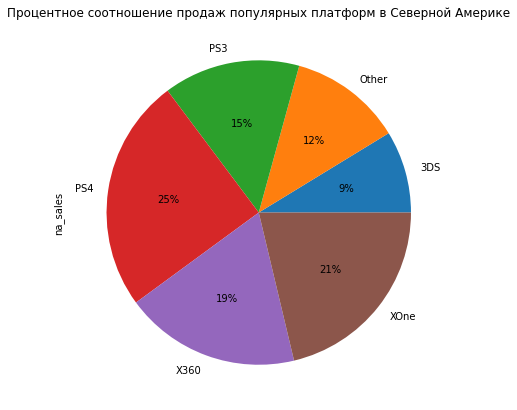

In [63]:
na_plot.plot(y='na_sales', kind='pie', figsize=(7, 7), autopct = '%1.0f%%', title = 'Процентное соотношение продаж популярных платформ в Северной Америке');

Топ-5 продаваемых платформ в Северной Америке: PS4(0.25), XOne(0.21), X360(0.19), PS3(0.14) и 3DS(0.09).

Выведем и визуализируем данные о продажах разных жанров в Северной Америке:

In [64]:
na_genre_rating = actual_period.pivot_table(index='genre', values=['name', 'na_sales'], aggfunc={'name': 'count', 'na_sales': 'sum'})
na_genre_rating.columns = ['na_sales', 'count']
na_genre_rating['sales_share'] = round(na_genre_rating['na_sales'] / (na_genre_rating['na_sales'].sum()), 2)
na_genre = na_genre_rating.sort_values(by='na_sales', ascending=False).reset_index()
na_genre

,genre,na_sales,count,sales_share
0,Action,126.05,766,0.29
1,Shooter,109.74,187,0.25
2,Sports,65.27,214,0.15
3,Role-Playing,46.40,292,0.11
4,Misc,27.49,155,0.06
5,Platform,18.14,74,0.04
6,Fighting,15.55,80,0.04
7,Racing,12.96,85,0.03
8,Adventure,7.14,245,0.02
9,Simulation,4.86,62,0.01


In [65]:
na_genre.loc[5:,'genre'] = 'Other'
na_plot_genre = na_genre.groupby('genre')['na_sales'].sum()

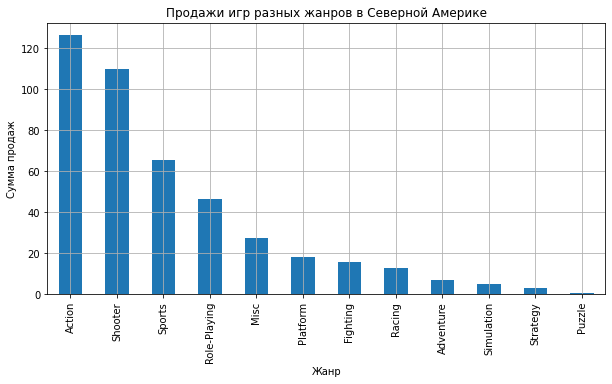

In [66]:
na_genre_rating['na_sales'].sort_values(ascending=False).plot.bar(figsize=(10, 5), grid=True)
plt.title('Продажи игр разных жанров в Северной Америке');
plt.xlabel('Жанр');
plt.ylabel('Сумма продаж');
plt.show()

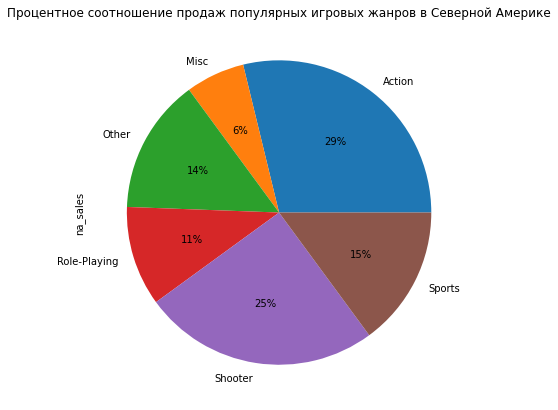

In [67]:
na_plot_genre.plot(y='na_sales', kind='pie', figsize=(7, 7), autopct = '%1.0f%%', title = 'Процентное соотношение продаж популярных игровых жанров в Северной Америке');

Топ-5 игровых жанров Северной Америки: Action(0.29), Shooter(0.25), Sports(0.15), Role_Playing(0.11) и Misc(0.06). 

Выведем данные продаж игр в зависимости от рейтинга ESRB в Северной Америке:

In [68]:
rating_sales_na = actual_period.pivot_table(index='rating', values=['name', 'na_sales'], aggfunc={'name': 'count', 'na_sales': 'sum'})
rating_sales_na.columns = ['na_sales', 'count']
rating_sales_na['sales_share'] = round(rating_sales_na['na_sales'] / (rating_sales_na['na_sales'].sum()), 2)
rating_sales_na.sort_values(by='na_sales', ascending=False).reset_index()

,rating,na_sales,count,sales_share
0,M,165.21,369,0.38
1,unknown,89.42,977,0.20
2,E,79.05,302,0.18
3,E10+,54.24,252,0.12
4,T,49.79,333,0.11


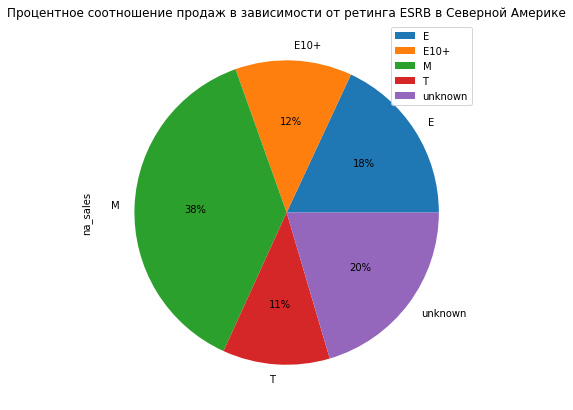

In [69]:
rating_sales_na.plot(y='na_sales', kind='pie', figsize=(7, 7), autopct = '%1.0f%%', title = 'Процентное соотношение продаж в зависимости от ретинга ESRB в Северной Америке');

В Северной Америке по продажам лидирует рейтинг M (для лиц старше 17 лет), далее идет неопределенный рейтинг, за ним -рейтинг E (для всех возрастных категорий), затем рейтинг E10+ (для лиц старше 10 лет) и незначительно отстает рейтинг Т (для лиц старше 13 лет).

Выведем и визуализируем продажи платформ в Европе:

In [70]:
eu_rating = actual_period.pivot_table(index='platform', values=['name', 'eu_sales'], aggfunc={'name': 'count', 'eu_sales': 'sum'})
eu_rating.columns = ['eu_sales', 'count']
eu_rating['sales_share'] = round(eu_rating['eu_sales'] / (eu_rating['eu_sales'].sum()), 2)
eu_platform = eu_rating.sort_values(by='eu_sales', ascending=False).reset_index()
eu_platform

,platform,eu_sales,count,sales_share
0,PS4,141.09,392,0.36
1,PS3,67.81,345,0.17
2,XOne,51.59,247,0.13
3,X360,42.52,186,0.11
4,3DS,30.96,303,0.08
5,PC,25.36,189,0.06
6,WiiU,19.85,115,0.05
7,PSV,6.10,358,0.02
8,Wii,5.93,23,0.02
9,DS,0.85,8,0.00


In [71]:
eu_platform.loc[5:,'platform'] = 'Other'
eu_plot = eu_platform.groupby('platform')['eu_sales'].sum()

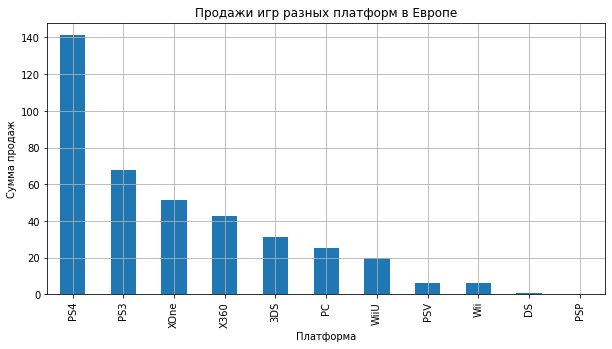

In [72]:
eu_rating['eu_sales'].sort_values(ascending=False).plot.bar(figsize=(10, 5), grid=True)
plt.title('Продажи игр разных платформ в Европе');
plt.xlabel('Платформа');
plt.ylabel('Сумма продаж');
plt.show()

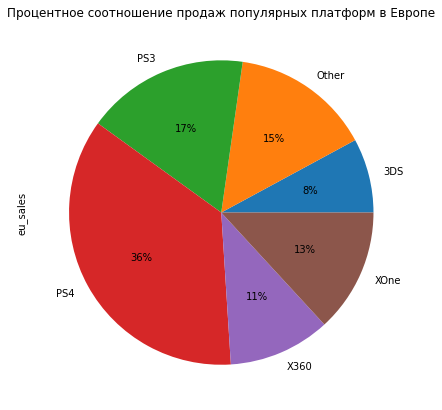

In [73]:
eu_plot.plot(y='eu_sales', kind='pie', figsize=(7, 7), autopct = '%1.0f%%', title = 'Процентное соотношение продаж популярных платформ в Европе');

Топ-5 продаваемых платформ в Европе: PS4(0.36), PS3(0.17), XOne(0.13), X360(0.11) и 3DS(0.08).

Выведем и визуализируем данные о продажах разных жанров в Европе:

In [74]:
eu_genre_rating = actual_period.pivot_table(index='genre', values=['name', 'eu_sales'], aggfunc={'name': 'count', 'eu_sales': 'sum'})
eu_genre_rating.columns = ['eu_sales', 'count']
eu_genre_rating['sales_share'] = round(eu_genre_rating['eu_sales'] / (eu_genre_rating['eu_sales'].sum()), 2)
eu_genre = eu_genre_rating.sort_values(by='eu_sales', ascending=False).reset_index()
eu_genre

,genre,eu_sales,count,sales_share
0,Action,118.13,766,0.30
1,Shooter,87.86,187,0.22
2,Sports,60.52,214,0.15
3,Role-Playing,36.97,292,0.09
4,Racing,20.19,85,0.05
5,Misc,20.04,155,0.05
6,Platform,15.58,74,0.04
7,Simulation,10.92,62,0.03
8,Fighting,8.55,80,0.02
9,Adventure,8.25,245,0.02


In [75]:
eu_genre.loc[5:,'genre'] = 'Other'
eu_plot_genre = eu_genre.groupby('genre')['eu_sales'].sum()

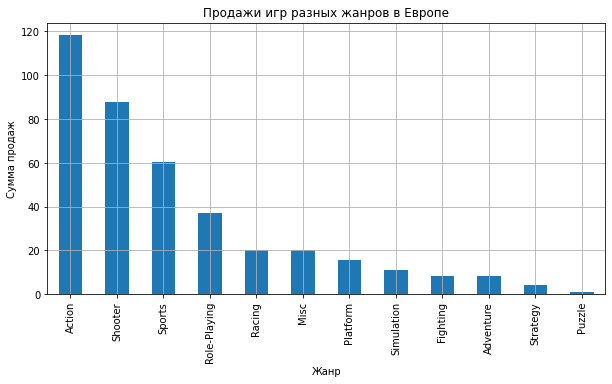

In [76]:
eu_genre_rating['eu_sales'].sort_values(ascending=False).plot.bar(figsize=(10, 5), grid=True)
plt.title('Продажи игр разных жанров в Европе');
plt.xlabel('Жанр');
plt.ylabel('Сумма продаж');
plt.show()

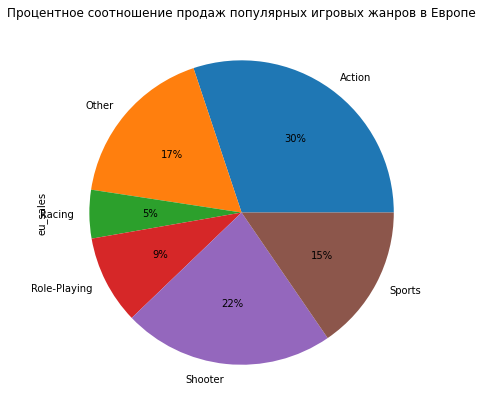

In [77]:
eu_plot_genre.plot(y='eu_sales', kind='pie', figsize=(7, 7), autopct = '%1.0f%%', title = 'Процентное соотношение продаж популярных игровых жанров в Европе');

Топ-5 игровых жанров Европы: Action(0.3), Shooter(0.22), Sports(0.15), Role_Playing(0.09) и Racing(0.05).

Выведем данные продаж игр в зависимости от рейтинга ESRB в Европе:

In [78]:
rating_sales_eu = actual_period.pivot_table(index='rating', values=['name', 'eu_sales'], aggfunc={'name': 'count', 'eu_sales': 'sum'})
rating_sales_eu.columns = ['eu_sales', 'count']
rating_sales_eu['sales_share'] = round(rating_sales_eu['eu_sales'] / (rating_sales_eu['eu_sales'].sum()), 2)
rating_sales_eu.sort_values(by='eu_sales', ascending=False).reset_index()

,rating,eu_sales,count,sales_share
0,M,145.32,369,0.37
1,E,83.36,302,0.21
2,unknown,78.91,977,0.20
3,E10+,42.69,252,0.11
4,T,41.95,333,0.11


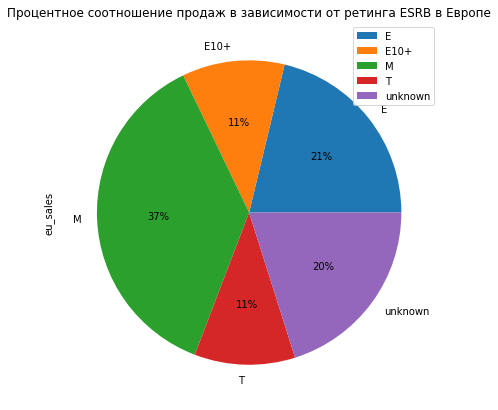

In [79]:
rating_sales_eu.plot(y='eu_sales', kind='pie', figsize=(7, 7), autopct = '%1.0f%%', title = 'Процентное соотношение продаж в зависимости от ретинга ESRB в Европе');

В Европе по продажам лидирует рейтинг M (для лиц старше 17 лет), далее идет рейтинг E (для всех возрастных категорий)  за ним - неопределенный рейтинг и рейтинги E10+ (для лиц старше 10 лет) и Т (для лиц старше 13 лет) идут последними.

Выведем и визуализируем продажи платформ в Японии:

In [80]:
jp_rating = actual_period.pivot_table(index='platform', values=['name', 'jp_sales'], aggfunc={'name': 'count', 'jp_sales': 'sum'})
jp_rating.columns = ['jp_sales', 'count']
jp_rating['sales_share'] = round(jp_rating['jp_sales'] / (jp_rating['jp_sales'].sum()), 2)
jp_platform = jp_rating.sort_values(by='jp_sales', ascending=False).reset_index()
jp_platform

,platform,jp_sales,count,sales_share
0,3DS,67.81,303,0.48
1,PS3,23.35,345,0.17
2,PSV,18.59,358,0.13
3,PS4,15.96,392,0.11
4,WiiU,10.88,115,0.08
5,PSP,3.29,67,0.02
6,X360,0.51,186,0.00
7,XOne,0.34,247,0.00
8,Wii,0.05,23,0.00
9,DS,0.00,8,0.00


In [81]:
jp_platform.loc[5:,'platform'] = 'Other'
jp_plot = jp_platform.groupby('platform')['jp_sales'].sum()

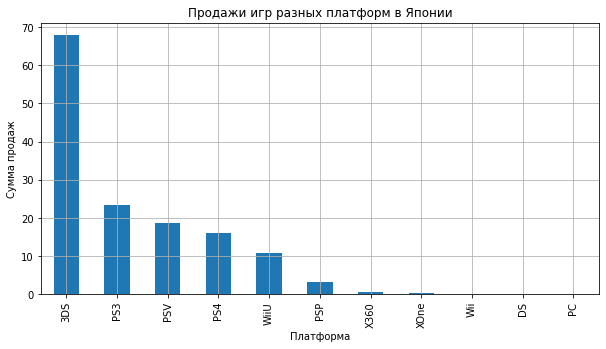

In [82]:
jp_rating['jp_sales'].sort_values(ascending=False).plot.bar(figsize=(10, 5), grid=True)
plt.title('Продажи игр разных платформ в Японии');
plt.xlabel('Платформа');
plt.ylabel('Сумма продаж');
plt.show()

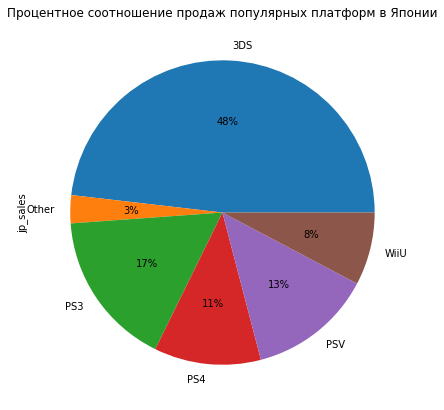

In [83]:
jp_plot.plot(y='jp_sales', kind='pie', figsize=(7, 7), autopct = '%1.0f%%', title = 'Процентное соотношение продаж популярных платформ в Японии');

Топ-5 продаваемых платформ в Японии: 3DS(0.48), PS3(0.17), PSV(0.13), PS4(0.11) и WiiU(0.08).

Выведем и визуализируем данные о продажах разных жанров в Японии:

In [84]:
jp_genre_rating = actual_period.pivot_table(index='genre', values=['name', 'jp_sales'], aggfunc={'name': 'count', 'jp_sales': 'sum'})
jp_genre_rating.columns = ['jp_sales', 'count']
jp_genre_rating['sales_share'] = round(jp_genre_rating['jp_sales'] / (jp_genre_rating['jp_sales'].sum()), 2)
jp_genre = jp_genre_rating.sort_values(by='jp_sales', ascending=False).reset_index()
jp_genre

,genre,jp_sales,count,sales_share
0,Role-Playing,51.04,292,0.36
1,Action,40.49,766,0.29
2,Misc,9.20,155,0.07
3,Fighting,7.65,80,0.05
4,Shooter,6.61,187,0.05
5,Adventure,5.82,245,0.04
6,Sports,5.41,214,0.04
7,Platform,4.79,74,0.03
8,Simulation,4.52,62,0.03
9,Racing,2.30,85,0.02


In [85]:
jp_genre.loc[5:,'genre'] = 'Other'
jp_plot_genre = jp_genre.groupby('genre')['jp_sales'].sum()

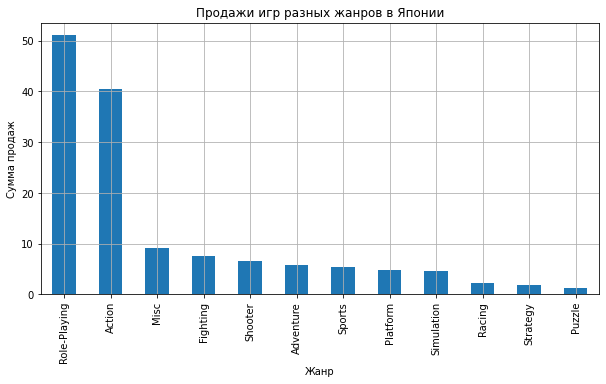

In [86]:
jp_genre_rating['jp_sales'].sort_values(ascending=False).plot.bar(figsize=(10, 5), grid=True)
plt.title('Продажи игр разных жанров в Японии');
plt.xlabel('Жанр');
plt.ylabel('Сумма продаж');
plt.show()

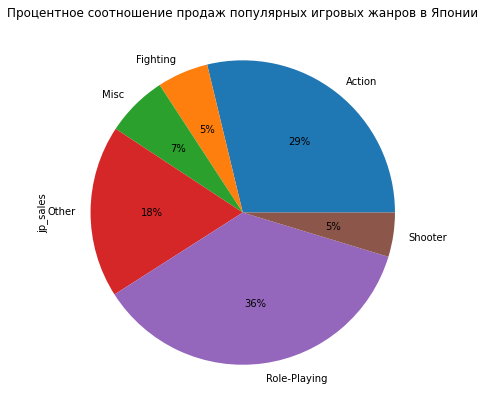

In [87]:
jp_plot_genre.plot(y='jp_sales', kind='pie', figsize=(7, 7), autopct = '%1.0f%%', title = 'Процентное соотношение продаж популярных игровых жанров в Японии');

Топ-5 игровых жанров Японии: Role_Playing(0.36), Action(0.29), Misc(0.07), Fighting(0.05) и Shooter(0.05).

Выведем данные продаж игр в зависимости от рейтинга ESRB в Японии:

In [88]:
rating_sales_jp = actual_period.pivot_table(index='rating', values=['name', 'jp_sales'], aggfunc={'name': 'count', 'jp_sales': 'sum'})
rating_sales_jp.columns = ['jp_sales', 'count']
rating_sales_jp['sales_share'] = round(rating_sales_jp['jp_sales'] / (rating_sales_jp['jp_sales'].sum()), 2)
rating_sales_jp.sort_values(by='jp_sales', ascending=False).reset_index()

,rating,jp_sales,count,sales_share
0,unknown,85.05,977,0.60
1,T,20.59,333,0.15
2,E,15.14,302,0.11
3,M,14.11,369,0.10
4,E10+,5.89,252,0.04


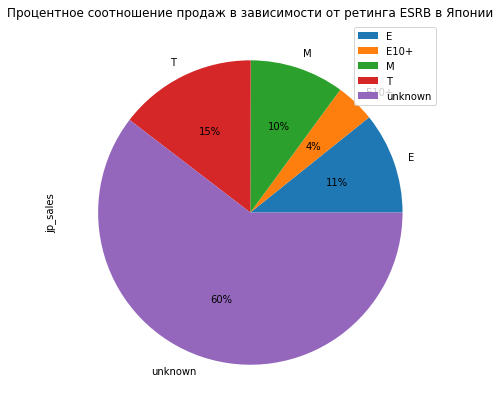

In [89]:
rating_sales_jp.plot(y='jp_sales', kind='pie', figsize=(7, 7), autopct = '%1.0f%%', title = 'Процентное соотношение продаж в зависимости от ретинга ESRB в Японии');

Как видно из полученных данных, лидером продаж в Японии, в основном, являются Японские платформы, а значит, у них хорошо развита игровая индустрия, отвечающая потребностям местного населения. В Японии совсем другая организация занимается присвоением возрастного рейтинга игре (CERO и EOCS), у них своя собственная маркировка, схожая с академической оценкой (A, B, C, D, Z).

В Японии по продажам лидирует неопределенный рейтинг, далее идет рейтинг Т (для лиц старше 13 лет), за ним -рейтинг E (для всех возрастных категорий), затем рейтинг M (для лиц старше 17 лет) и рейтинг рейтинг E10+ (для лиц старше 10 лет).

**Подытожим:**
 - Топ-5 продаваемых платформ в Северной Америке: PS4(0.25), XOne(0.21), X360(0.19), PS3(0.14) и 3DS(0.09).
 - Топ-5 игровых жанров Северной Америки: Action(0.29), Shooter(0.25), Sports(0.15), Role_Playing(0.11) и Misc(0.06).
 - В Северной Америке по продажам лидирует рейтинг M (для лиц старше 17 лет), далее идет неопределенный рейтинг, за ним - рейтинг E (для всех возрастных категорий), затем рейтинг E10+ (для лиц старше 10 лет) и незначительно отстает рейтинг Т (для лиц старше 13 лет).
 - Топ-5 продаваемых платформ в Европе: PS4(0.36), PS3(0.17), XOne(0.13), X360(0.11) и 3DS(0.08).
 - Топ-5 игровых жанров Европы: Action(0.3), Shooter(0.22), Sports(0.15), Role_Playing(0.09) и Racing(0.05).
 - В Европе по продажам лидирует рейтинг M (для лиц старше 17 лет), далее идет рейтинг E (для всех возрастных категорий) за ним - неопределенный рейтинг и рейтинги E10+ (для лиц старше 10 лет) и Т (для лиц старше 13 лет) идут последними.
 - Топ-5 продаваемых платформ в Японии: 3DS(0.48), PS3(0.17), PSV(0.13), PS4(0.11) и WiiU(0.08).
 - Топ-5 игровых жанров Японии: Role_Playing(0.36), Action(0.29), Misc(0.07), Fighting(0.05) и Shooter(0.05).
 - В Японии по продажам лидирует неопределенный рейтинг, далее идет рейтинг Т (для лиц старше 13 лет), за ним -рейтинг E (для всех возрастных категорий), затем рейтинг M (для лиц старше 17 лет) и рейтинг рейтинг E10+ (для лиц старше 10 лет).

Таким образом:
 - Типичный пользователь из Северной Америки предпочитает иговые платформы: PS4, XOne и X360, играет в игры жанров Action, Shooter и Sports с возрастным рейтингом M;
 - Типичный пользователь из Европы предпочитает иговые платформы: PS4, PS3, XOne, играет в игры жанров Action, Shooter и Sports с возрастным рейтингом M;
 - Типичный пользователь из Японии предпочитает иговые платформы: 3DS, PS3, PSV, играет в игры жанров Role_Playing, Action, Misc, с неопределенным возрастным рейтингом;

# Статистический анализ

Необходимо проверить ряд гипотез.

**Гипотеза 1:** Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;

Сформулируем гипотезы:
 - H(0): Средние пользовательские рейтинги платформ Xbox One и PC равны;
 - Н(1): Средние пользовательские рейтинги платформ Xbox One и PC не равны;

Подготовка выборок для теста:

In [90]:
xone_data = actual_period.query('platform == "XOne"').dropna()
pc_data = actual_period.query('platform == "PC"').dropna()

Для проверки двусторонней гипотезы используем Т-тест для оценки равенства двух средних независимых выборок:

In [91]:
alpha = 0.05

results = st.ttest_ind(xone_data['user_score'], pc_data['user_score'])
equal_var=False
print('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.17306926618147322
Не получилось отвергнуть нулевую гипотезу


Есть основание утверждать, что средние пользовательские рейтинги платформ Xbox One и PC равны.

P-value показывает нам, что с вероятностью 17.3% можно получить равные средние пользовательские рейтинги платформ Xbox One и PC.

Выведем средние значения оценок пользователей XOne и PC:

In [92]:
xone_data['user_score'].mean()

6.538181818181818

In [93]:
pc_data['user_score'].mean()

6.3020270270270276

Пользовательские оценки платформ XOne и PC довольно близки, разница составляет - 0.24.

**Гипотеза 2:** Средние пользовательские рейтинги жанров Action и Sports  разные.

Сформулируем гипотезы:
 - H(0): Средние пользовательские рейтинги жанров Action и Sports равны;
 - Н(1): Средние пользовательские рейтинги жанров Action и Sports разные;

Подготовка выборок для теста

In [94]:
action_data = actual_period.query('genre == "Action"').dropna()
sports_data = actual_period.query('genre == "Sports"').dropna()

Для проверки двусторонней гипотезы используем Т-тест для оценки равенства двух средних независимых выборок:

In [95]:
alpha = 0.05

results = st.ttest_ind(action_data['user_score'], sports_data['user_score'])
equal_var=False
print('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 1.684099430689953e-16
Отвергаем нулевую гипотезу


Нет оснований утверждать, что средние пользовательские рейтинги жанров Action и Sports равны.

Выведем средние значения пользовательских рейтингов жанров Action и Sports:

In [96]:
action_data['user_score'].mean()

6.9362459546925574

In [97]:
sports_data['user_score'].mean()

5.665454545454545

Значения различаются примерно на 1.26, это существенная разница.

# Общий вывод

В ходе выполнения проекта:
 - была получена общая информация о датафрейме (исходный датафрейм содержит всего 16715 строк, 11 столбцов. Названия столбцов записаны некорректно. Данные имеют тип float64 и object);
 - в ходе предобработки данных:
 1. были приведены названия столбцов к нижнему регистру;
 2. также обнаружили пропуски в 6 столбцах (в столбце с оценками критиков (51.31 %), с оценками пользователей (40.08 %) и рейтингом от организации ESRB (40.47), значительно меньше пропусков в столбцах с годами выпуска, с названием игр и жанрами). Пропуски были обработаны разными способами;
 3. был изменен тип данных: "Год выпска" с типа float на integer, "оценки пользователей" с типа object на float;
 4. данные проверили на наличие явных дубликатов: дубликатов не обнаружено;
 5. добавили столбец 'total_sales' с суммарными продажами по всем регионам.
 - был проведен исследовательский анализ данных:
 1. **Сколько игр выпускалось в разные годы:** Максимальное число игр выпускалось в 2008 году (9.12 %). Наибольшее количество игр выпускалось в период с 2005 по 2011 год, далее идет спад, обусловленный, по-видимому, меньшему интересу к играм. Минимальное количество игр было выпущено в 1980 году (0.05 %). Если опираться на количество игр, то до 2002 года данные не так интересны. Наиболее актуальные период для исследования от 2005 года.
 2. **Как менялись продажи по платформам:** были выявлены платформы с наибольшими суммарными продажами ( 6 платформ - PS2, X360, PS3, Wii, DS, PS значительно превосходят по продажам все остальные платформы). Было изучено распределение продаж платформ по годам (у всех платформ сначала идет постепенный рост количества игр с течением времени, затем достигается пиковое значеие, и далее идет спад, т.к.теряется актуальность платформы). В среднем, за период в 11 лет исчезают старые и появляются новые платформы. 2008-2011 год характеризуются максимальной актуальностью сразу четырех платформ: DS, Wii, X360 и PS3.
 3. **Актуальный период** Исходя из предыдущих исследований выбрали актуальный период для дальнейших исследований, начиная с 2013 года с учетом того, что данные должны помочь построить прогноз на 2017 год.
 4. **Какие платформы лидируют по продажам** изучив данные за актуальный период от 2013 года, был сделан вывод, что рейтинг по продажам возглавляет платформа PS4. Далее идет платформа PS3, но на графике наблюдается сильный спад продаж на момент 2016 года. На третьем месте платформа XOne, на четвертом 3DS, на пятом X360. Потенциально прибыльными можно назвать PS4, XOne и 3DS. Однако, на графике виден их постепенный спад продаж на 2016 год.
 5. **Диаграмма размаха глобальных продаж игр в разбивке по платформам** Изучив описательные данные и диаграмму размаха был сделан вывод, что можно выявить лидеров продаж: X360, Wii, PS4, XOne. Данные по всем платформам характеризуются большим разбросом значений.
 6. **Влияние отзывов пользователей и критиков на продажи внутри платформы** Изучив данные по пяти платформам, можно сделать вывод, что коэффициент корреляции продаж и оценок критиков у всех платформах имеет значение около 0.4. Это говорит о небольшой прямопропорциональной связи. Это можно наблюдать на диаграммах рассеяния. С увеличением оценки критика растут продажи платформы. Коэффициент корреляции продаж и оценок пользователей на всех платформах на уровне 0.03, это говорит, что связи практически нет между этими параметрами.
 7. **Общее распределение игр по жанрам** Самым часто выпускаемым жанром можно назвать Action, у него большой отрыв в сравнении с остальными жанрами. Топ-5 выпускаемых жанров: Action, Role-Playing, Adventure, Sports и Shooter. Самый не популярный жанр - Puzzle. Лидером продаж является жанр Shooter, далее идут: Sports, Platform, Role-Playing и Fighting. Наименьшие продажи у жанра Adventure.
 8. **Портрет пользователя каждого региона** Типичный пользователь из Северной Америки предпочитает иговые платформы: PS4, XOne и X360, играет в игры жанров Action, Shooter и Sports с возрастным рейтингом M. Типичный пользователь из Европы предпочитает иговые платформы: PS4, PS3, XOne, играет в игры жанров Action, Shooter и Sports с возрастным рейтингом M. Типичный пользователь из Японии предпочитает иговые платформы: 3DS, PS3, PSV, играет в игры жанров Role_Playing, Action, Misc, с неопределенным возрастным рейтингом.
 - был проведен статистический анализ, а именно: проверка двух гипотез, в ходе которой были сделаны следующие выводы: с вероятностью 17.3% можно получить равные средние пользовательские рейтинги платформ Xbox One и PC.; нет оснований утверждать, что средние пользовательские рейтинги жанров Action и Sports равны.

Лидирующие позиции в игровой индустрии занимают платформы: PS4 и XOne. Оценки критиков имеют слабое влияние на продажи, а связи с оценками пользователей не наблюдается. Наиболее продающиеся жанры - Shooter и Sport. Предпочтительный возрастной рейтинг организации ESRB - M (для лиц старше 17 лет).